In [1]:
import os
import numpy as np
from simulation_module import SimulationConfig, SimulationState, SimulationRunner, SimulationIO, SimulationVisualizer, AnimationMaker
from laser import Laser
import parralel
from time import time
from parralel_workers import process_single_rolling_average_density_map
from dataclasses import asdict #(for asdict)
start0 = time()

laser650 = laser650 = Laser(650, [1,0], saturation = 10, detuning = -2 * np.pi * 20 / 2, Gamma = 2 * np.pi * 20)

dt_exponent = -3
num_steps_exponent = 4
num_quenches = 30
num_workers = 7
N = 2
gamma = 0.1

filename = f"{N}_{gamma}_positions_1.json"
assert os.path.exists(filename), f"File '{filename}' not found. You need to generate a starting configuration for that value of N, it seems like you don't have one. Try N = 6, gamma = 1 for example."

# SHORT CONFIG
config = SimulationConfig(
    N = N,
    w = 1.0,
    g = gamma,
    m = 137.327,  # mass in atomic units
    T_mK = 0,     # temperature in mK
    dt = 10**dt_exponent,
    num_steps = int(10**num_steps_exponent),
    damping = False,
    damping_parameter = 1.0,
    langevin_temperature = False,
    lasers=[laser650]  # or a list of Laser instances
)

total_steps_per_worker = num_quenches * config.num_steps/num_workers
print(f"Total number of simulated timesteps per worker = {(total_steps_per_worker / (10**6)):.3f} million steps per worker. Expected time = {(total_steps_per_worker * 0.000095954544):.3f} s")

config.save_shortform()

state = SimulationState(config)
state.positions = SimulationIO.load_positions(f"{N}_{config.g}_positions_1.json")
state.initial_positions = state.positions.copy()
state.initialized = True

# Use Eddie's user-specific scratch space
scratch_base = "" #"/exports/eddie/scratch/s2142953"

quench_trajectory_folder = os.path.join(scratch_base, "quench_folder")
animation_folder = os.path.join(scratch_base, "animation_folder")
temperature_folder = os.path.join(scratch_base, "temperature_folder")
animation_output = "animation_output"
rolling_average_output = "rolling_average_output"

# Make sure folders exist
os.makedirs(quench_trajectory_folder, exist_ok=True)
os.makedirs(animation_folder, exist_ok=True)
os.makedirs(temperature_folder, exist_ok=True)
os.makedirs(animation_output, exist_ok = True)

Total number of simulated timesteps per worker = 0.043 million steps per worker. Expected time = 4.112 s


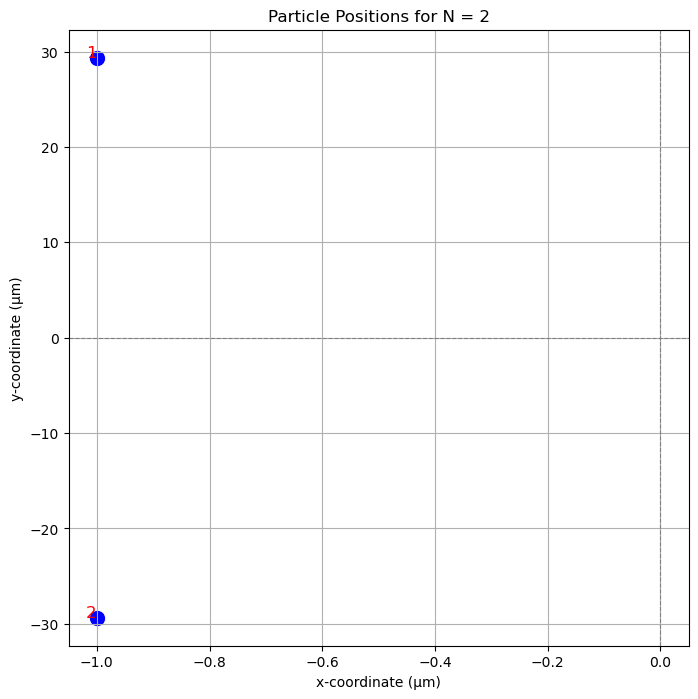

In [42]:
SimulationVisualizer().plot_positions(state, square = False)

In [37]:
start = time()
parralel.run_quench_series(
    config = config,
    loadfile = f"{N}_{config.g}_positions_1.json",
    output_dir = quench_trajectory_folder,
    g_start = 0.1,
    g_end = 0.9,
    g_step = num_quenches,
    num_workers = num_workers
)    
print(f"Time taken to quench = {time()-start:.3f} s")

Beginning to parralel quench
Running gamma = 0.26551724
Running with isotropy (γ) = 0.2655 for 10.0 μs
Running gamma = 0.43103448
Running with isotropy (γ) = 0.4310 for 10.0 μs
Running gamma = 0.62413793
Running with isotropy (γ) = 0.6241 for 10.0 μs
Running gamma = 0.76206897
Running with isotropy (γ) = 0.7621 for 10.0 μs
Running gamma = 0.12758621
Running with isotropy (γ) = 0.1276 for 10.0 μs
Running gamma = 0.34827586
Running with isotropy (γ) = 0.3483 for 10.0 μs
Running gamma = 0.54137931
Running with isotropy (γ) = 0.5414 for 10.0 μs
Running gamma = 0.73448276
Running with isotropy (γ) = 0.7345 for 10.0 μs
Running gamma = 0.21034483
Running with isotropy (γ) = 0.2103 for 10.0 μs
Running gamma = 0.40344828
Running with isotropy (γ) = 0.4034 for 10.0 μs
Running gamma = 0.56896552
Running with isotropy (γ) = 0.5690 for 10.0 μs
Running gamma = 0.78965517
Running with isotropy (γ) = 0.7897 for 10.0 μs
Running gamma = 0.18275862
Running with isotropy (γ) = 0.1828 for 10.0 μs
Running g

In [38]:
start = time()
parralel.generate_rolling_average_density_map_images_from_quench_folder(
    traj_folder = quench_trajectory_folder,
    output_dir = rolling_average_output,
    base_config = config,
    time_per_image = 5,
    overlapping_time = 0,
    full_histogram = True,
    animate = True,
    num_workers = num_workers)
print(f"Time taken to generate rolling images = {time()-start:.3f} s")

🔁 Beginning parallel rolling-average density map generation
Saved rolling_average_output/2_0.84482758620690_traj_10000_steps/rolling_frame_002_window_000_gamma_0.844828.png
Saved rolling_average_output/2_0.84482758620690_traj_10000_steps/rolling_frame_002_window_001_gamma_0.844828.png
Saved rolling_average_output/2_0.70689655172414_traj_10000_steps/rolling_frame_007_window_000_gamma_0.706897.png
Saved rolling_average_output/2_0.70689655172414_traj_10000_steps/rolling_frame_007_window_001_gamma_0.706897.png
Saved rolling_average_output/2_0.45862068965517_traj_10000_steps/rolling_frame_016_window_000_gamma_0.458621.png
Saved rolling_average_output/2_0.45862068965517_traj_10000_steps/rolling_frame_016_window_001_gamma_0.458621.png
Saved rolling_average_output/2_0.21034482758621_traj_10000_steps/rolling_frame_025_window_000_gamma_0.210345.png
Saved rolling_average_output/2_0.21034482758621_traj_10000_steps/rolling_frame_025_window_001_gamma_0.210345.png
Saved rolling_average_output/2_0.872

TypeError: plot_density_map_from_histogram() missing 1 required positional argument: 'square'

In [6]:
start = time()
parralel.generate_density_map_images_from_quench_folder(quench_trajectory_folder, 
                                                        animation_folder, 
                                                        config, 
                                                        num_workers = num_workers,
                                                       square = False                                                       )
print(f"Time taken to process images = {time()-start:.3f} s")

Beginning to parralel process trajectory files
Processing quench_folder/10_0.45862068965517_traj_10000_steps.json
Processing quench_folder/10_0.37586206896552_traj_10000_steps.json
Processing quench_folder/10_0.27931034482759_traj_10000_steps.json
Processing quench_folder/10_0.18275862068966_traj_10000_steps.json
Processing quench_folder/10_0.44482758620690_traj_10000_steps.json
Processing quench_folder/10_0.36206896551724_traj_10000_steps.json
Processing quench_folder/10_0.26551724137931_traj_10000_steps.json
Processing quench_folder/10_0.16896551724138_traj_10000_steps.json
Processing quench_folder/10_0.47241379310345_traj_10000_steps.json
Processing quench_folder/10_0.34827586206897_traj_10000_steps.json
Processing quench_folder/10_0.23793103448276_traj_10000_steps.json
Processing quench_folder/10_0.15517241379310_traj_10000_steps.json
Processing quench_folder/10_0.41724137931034_traj_10000_steps.json
Processing quench_folder/10_0.32068965517241_traj_10000_steps.json
Processing quen

In [5]:
# start = time()
# AnimationMaker.make_gif_or_mp4_from_images(animation_folder, f"{animation_output}/--output_animation_dt_1e{dt_exponent}_num_1e{num_steps_exponent}_time_{int(10**(dt_exponent+num_steps_exponent))}us.mp4", fps=6, reverse = True)
# print(f"Time taken to make animation = {time()-start:.3f} s")

In [6]:
# start = time()
# parralel.generate_temperature_plots_from_quench_folder(quench_trajectory_folder,temperature_folder,config, grainyness=100,num_workers=num_workers)
# print(f"Time taken to make temperature plots {time()-start:.5f} s")

In [7]:
# start = time()
# AnimationMaker.make_gif_or_mp4_from_images(temperature_folder, f"{animation_output}/--temperature_animation_dt_1e{dt_exponent}_num_1e{num_steps_exponent}_time_{int(10**(dt_exponent+num_steps_exponent))}us.mp4", fps=6, reverse = False)
# print(f"Time taken to make temperature animation = {time()-start:.3f} s")

In [11]:
config.save_shortform()